In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc
plt.style.use('fivethirtyeight')
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex = True)

In [2]:
class LNN:
    def __init__(self, N, v = None, w = None, sigmaS = 1., sigmaI = 1., sigmaG = 1., nonlinearity = None):
        self.N = N
        if v is None:
            self.v = 0
        else:
            self.v = v
        
        if w is None:
            self.w = 0
        else:
            self.w = w
        
        if nonlinearity is None:
            self.nonlinearity = self.squared
        else:
            self.nonlinearity = nonlinearity
        
        self.sigmaS = sigmaS
        self.sigmaI = sigmaI
        self.sigmaG = sigmaG
    
    def squared(self,x):
        return x**2

    def simulate(self,trials):
        s = np.random.normal(loc = 0., scale = sigmaG, size = trials)
        injected_noise = np.random.normal(loc = 0., scale = sigmaI, size = trials)
        private_noise = np.random.normal(loc = 0., scale = sigmaG, size = (self.N, trials))
        l = np.outer(self.v, s) + np.outer(self.w, injected_noise) + private_noise
        r = self.nonlinearity(l)
        return r
    
    def mutual(self):
        v2 = np.sum(self.v**2)
        w2 = np.sum(self.w**2)
        vdotw = np.sum(self.v * self.w)
        ww = np.outer(self.w, self.w)
        wv = np.outer(self.w, self.v)
        vw = np.outer(self.v, self.w)
        vv = np.outer(self.v, self.v)
        
        sigma_inj = self.sigmaG**2 + self.sigmaI**2 * w2
        sigma_stim = self.sigmaG**2 + self.sigmaS**2 * v2
        kappa = sigma_inj * sigma_stim - self.sigmaI**2 * self.sigmaS**2 * vdotw**2
        
        I1 = -np.log(self.sigmaG) + 0.5 *np.log(kappa/sigma_inj)
        
        B1 = -(self.sigmaI**4 * self.sigmaS**2 * vdotw**2)/(2 * self.sigmaG**2 * kappa * sigma_inj)
        B2 = (self.sigmaI**2 * self.sigmaS**2 * vdotw)/(self.sigmaG**2 * kappa)
        B3 = -(self.sigmaS**2 * sigma_inj)/(2 * self.sigmaG**2 * kappa)
        B = B1 * ww + B2 * wv + B3 * vv
        
        A1 = -self.sigmaI**2 * sigma_stim/kappa
        A2 = 2 * self.sigmaI**2 * self.sigmaS**2 * vdotw/kappa
        A3 = -self.sigmaS**2 * sigma_inj/kappa
        
        det_Ap = 1 + A1 * w2 + A2 * vdotw + A3 * v2 + A1 * A3 * (v2 * w2 - vdotw**2)
        Ap_inv = np.identity(self.N) - (A1 * ww + A2 * wv + A3 * vv)/det_Ap - A1 * A3 * (w2 * vv + v2 * ww - vdotw * (vw + wv))/det_Ap
        I2 = 2 * self.sigmaG**4/np.sqrt(kappa * det_Ap) * np.trace(np.dot(B, Ap_inv))
        
        C = kappa * self.sigmaG**2 * sigma_inj * (self.sigmaG**2 * v2 + self.sigmaI**2 * (v2 * w2 - vdotw**2))
        gamma = (self.sigmaG**2 + sigma_stim) * sigma_inj - self.sigmaI**2 * self.sigmaS**2 * vdotw**2
        D = gamma * (-self.sigmaI**4 * vdotw**2 * ww + 2 * self.sigmaI**2 * vdotw * sigma_inj * wv - sigma_inj**2 * vv)

        I3 = -self.sigmaS**2/(2 * kappa**(2.5) * sigma_inj * np.sqrt(det_Ap)) \
            * (C + 2 * self.sigmaG**2 * np.trace(np.dot(D, Ap_inv)))
        return I1 + I2 + I3
    
    def detA(self):
        v2 = np.sum(self.v**2)
        w2 = np.sum(self.w**2)
        vdotw = np.sum(self.v * self.w)
        
        A1 = -self.sigmaI**2 * sigma_stim/kappa
        A2 = 2 * self.sigmaI**2 * self.sigmaS**2 * vdotw/kappa
        A3 = -self.sigmaS**2 * sigma_inj/kappa
        
        return 1 + A1 * w2 + A2 * vdotw + A3 * v2 + A1 * A3 * (v2 * w2 - vdotw**2)

    def check_A_det(self):
        v2 = np.sum(self.v**2)
        w2 = np.sum(self.w**2)
        vdotw = np.sum(self.v * self.w)
        ww = np.outer(self.w, self.w)
        wv = np.outer(self.w, self.v)
        vw = np.outer(self.v, self.w)
        vv = np.outer(self.v, self.v)
        
        sigma_inj = self.sigmaG**2 + self.sigmaI**2 * w2
        sigma_stim = self.sigmaG**2 + self.sigmaS**2 * v2
        kappa = sigma_inj * sigma_stim - self.sigmaI**2 * self.sigmaS**2 * vdotw**2

        A1 = -self.sigmaI**2 * sigma_stim/kappa
        A2 = 2 * self.sigmaI**2 * self.sigmaS**2 * vdotw/kappa
        A3 = -self.sigmaS**2 * sigma_inj/kappa
        
        A = 1./(2. * self.sigmaG**2) * (np.identity(self.N) + A1 * ww + A2 * wv + A3 * vv)
        A_det_numeric = np.linalg.det(A)
        A_det_analytic = (1 + A1 * w2 + A2 * vdotw + A3 * v2 + A1 * A3 * (v2 * w2 - vdotw**2))/(2 * self.sigmaG**2)**self.N
        return A_det_numeric, A_det_analytic
    
    def check_A_inv(self):
        v2 = np.sum(self.v**2)
        w2 = np.sum(self.w**2)
        vdotw = np.sum(self.v * self.w)
        ww = np.outer(self.w, self.w)
        wv = np.outer(self.w, self.v)
        vw = np.outer(self.v, self.w)
        vv = np.outer(self.v, self.v)
        
        sigma_inj = self.sigmaG**2 + self.sigmaI**2 * w2
        sigma_stim = self.sigmaG**2 + self.sigmaS**2 * v2
        kappa = sigma_inj * sigma_stim - self.sigmaI**2 * self.sigmaS**2 * vdotw**2

        A1 = -self.sigmaI**2 * sigma_stim/kappa
        A2 = 2 * self.sigmaI**2 * self.sigmaS**2 * vdotw/kappa
        A3 = -self.sigmaS**2 * sigma_inj/kappa
        
        A = 1./(2. * self.sigmaG**2) * (np.identity(self.N) + A1 * ww + A2 * wv + A3 * vv)
        A_inv_numeric = np.linalg.inv(A)
        
        denom = 1 + A1 * w2 + A2 * vdotw + A3 * v2 + A1 * A3 * (v2 * w2 - vdotw**2)
        A_inv_analytic = 2 * self.sigmaG**2 * (np.identity(self.N) - (A1 * ww + A2 * wv + A3 * vv)/denom - A1 * A3 * (w2 * vv + v2 * ww - vdotw * (vw + wv))/denom)
        return A_inv_numeric, A_inv_analytic
    
    def check_A_trace(self):
        v2 = np.sum(self.v**2)
        w2 = np.sum(self.w**2)
        vdotw = np.sum(self.v * self.w)
        ww = np.outer(self.w, self.w)
        wv = np.outer(self.w, self.v)
        vw = np.outer(self.v, self.w)
        vv = np.outer(self.v, self.v)
        
        sigma_inj = self.sigmaG**2 + self.sigmaI**2 * w2
        sigma_stim = self.sigmaG**2 + self.sigmaS**2 * v2
        kappa = sigma_inj * sigma_stim - self.sigmaI**2 * self.sigmaS**2 * vdotw**2
        A1 = -self.sigmaI**2 * sigma_stim/kappa
        A2 = 2 * self.sigmaI**2 * self.sigmaS**2 * vdotw/kappa
        A3 = -self.sigmaS**2 * sigma_inj/kappa
        
        B1 = -(self.sigmaI**4 * self.sigmaS**2 * vdotw**2)/(2 * self.sigmaG**2 * kappa * sigma_inj)
        
        B = 1/(2 * self.sigmaG**2) * (B1 * ww + A2 * wv + A3 * vv)
        A = 1/(2 * self.sigmaG**2) * (np.identity(self.N) + A1 * ww + A2 * wv + A3 * vv)
        Ainv = np.linalg.inv(A)
        denom = 1 + A1 * w2 + A2 * vdotw + A3 * v2 + A1 * A3 * (v2 * w2 - vdotw**2)
        #Ainv = (np.identity(self.N) - (A1 * ww + A2 * wv + A3 * vv)/denom - A1 * A3 * (w2 * vv + v2 * ww - vdotw * (vw + wv))/denom)
        
        numeric = np.trace(np.dot(B, Ainv))
        numeric = np.trace(np.dot(B, Ainv))
        analytic = (A2*vdotw + B1*w2 + A3 * (v2 - (A1 + B1) * vdotw**2 + (A1 + B1) * v2 * w2))/denom
        return numeric, analytic

In [3]:
ns1 = np.arange(500)
muts1 = np.zeros(ns1.shape)

for idx, n in enumerate(ns1):
    lnn = LNN(n, v = np.ones(n), w = np.ones(n))
    muts1[idx] = lnn.mutual()

ns2 = np.arange(2, 500, 2)
muts2 = np.zeros(ns2.shape)

for idx, n in enumerate(ns2):
    v = np.ones(n)
    w = np.concatenate((np.ones(int(n/2)), 2 * np.ones(int(n/2))))
    lnn = LNN(n, v = v, w = w)
    muts2[idx] = lnn.mutual()

ns3 = np.arange(3, 500, 3)
muts3 = np.zeros(ns3.shape)
for idx, n in enumerate(ns3):
    v = np.ones(n)
    w = np.concatenate((np.ones(int(n/3)), 2 * np.ones(int(n/3)), 3 * np.ones(int(n/3))))
    lnn = LNN(n, v = v, w = w)
    muts3[idx] = lnn.mutual()

nsN = np.arange(1, 500, 1)
mutsN = np.zeros(nsN.shape)
for idx, n in enumerate(nsN):
    v = np.ones(n)
    w = np.arange(1, n+1)
    lnn = LNN(n, v = v, w = w)
    mutsN[idx] = lnn.mutual()

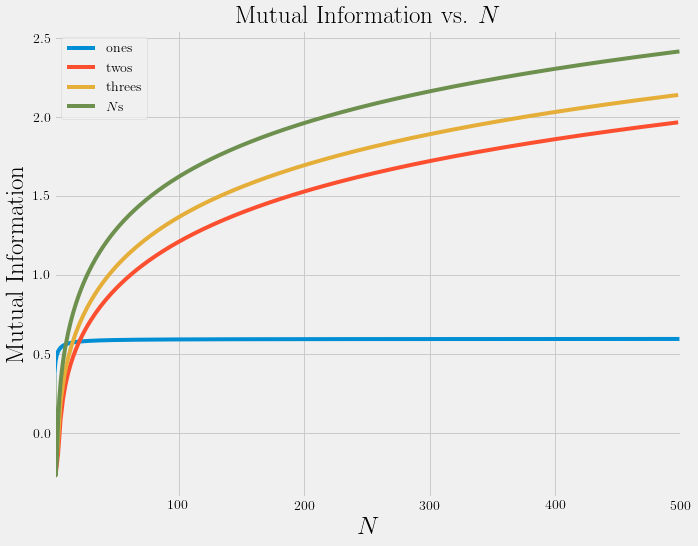

In [23]:
plt.figure(figsize = (10,8))
plt.plot(ns1, muts1, label = 'ones')
plt.plot(ns2, muts2, label = 'twos')
plt.plot(ns3, muts3, label = 'threes')
plt.plot(nsN, mutsN, label = r'$N$s')
plt.legend(loc = 2)
plt.xlim([1, 500])
plt.title(r'Mutual Information vs. $N$', fontsize = 25)
plt.xlabel(r'$N$', fontsize = 25)
plt.ylabel('Mutual Information', fontsize = 25)

In [18]:
muts2

array([-0.26867197, -0.13109088,  0.08584785,  0.21886796,  0.3099641 ,
        0.37921017,  0.43561911,  0.48368919,  0.52590738,  0.56377052,
        0.598244  ,  0.62998646,  0.6594684 ,  0.68703892,  0.71296526,
        0.73745747,  0.76068425,  0.78278368,  0.80387053,  0.82404153,
        0.84337913,  0.86195437,  0.87982896,  0.89705694,  0.91368599,
        0.9297584 ,  0.94531193,  0.96038044,  0.97499441,  0.98918145,
        1.00296662,  1.01637276,  1.02942075,  1.04212974,  1.05451733,
        1.06659976,  1.07839204,  1.08990805,  1.1011607 ,  1.11216198,
        1.12292307,  1.13345441,  1.14376575,  1.15386623,  1.16376441,
        1.17346836,  1.18298563,  1.19232337,  1.2014883 ,  1.21048676,
        1.21932477,  1.22800799,  1.23654181,  1.24493132,  1.25318138,
        1.26129657,  1.26928128,  1.27713966,  1.28487568,  1.29249311,
        1.29999557,  1.3073865 ,  1.31466917,  1.32184675,  1.32892223,
        1.3358985 ,  1.34277831,  1.34956432,  1.35625905,  1.36

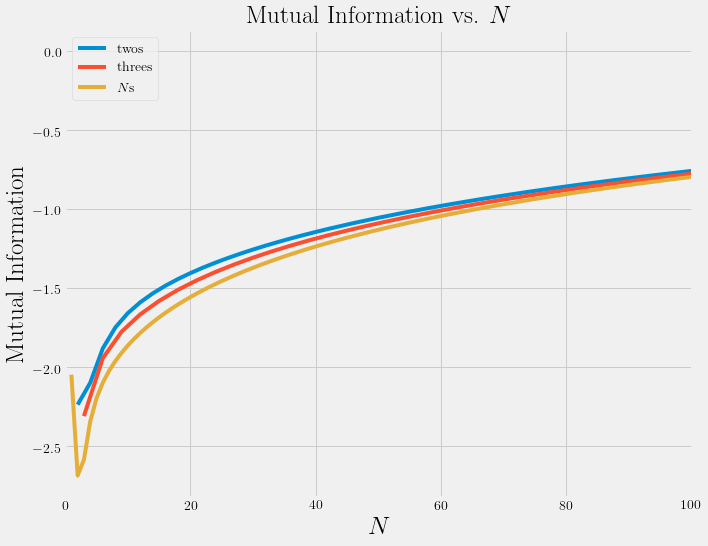

In [15]:
plt.figure(figsize = (10,8))
#plt.plot(ns1, muts1 , label = 'ones')
plt.plot(ns2, muts2 - muts2[-1], label = 'twos')
plt.plot(ns3, muts3 - muts3[-1], label = 'threes')
plt.plot(nsN, mutsN - mutsN[-1], label = r'$N$s')
plt.xlim([0, 100])
plt.legend(loc = 2)
plt.title(r'Mutual Information vs. $N$', fontsize = 25)
plt.xlabel(r'$N$', fontsize = 25)
plt.ylabel('Mutual Information', fontsize = 25)

In [14]:
muts2[-1] - muts3[-1]

-0.17331001002429192